In [1]:
import bline_correction as bc 
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import seaborn as sns
from scipy.ndimage import maximum_filter1d, minimum_filter1d
import pandas as pd

plt.style.use(['science','nature', 'notebook', 'grid'])

In [2]:
np.random.seed(42)
x = np.linspace(0, 10, 1000)
y_true = 2 * np.sin(2 * x) + 3 * np.cos(3 * x)
baseline = 5 + 0.5 * x + 0.1 * x**2
y_noisy = y_true + baseline + np.random.normal(0, 1, x.shape)


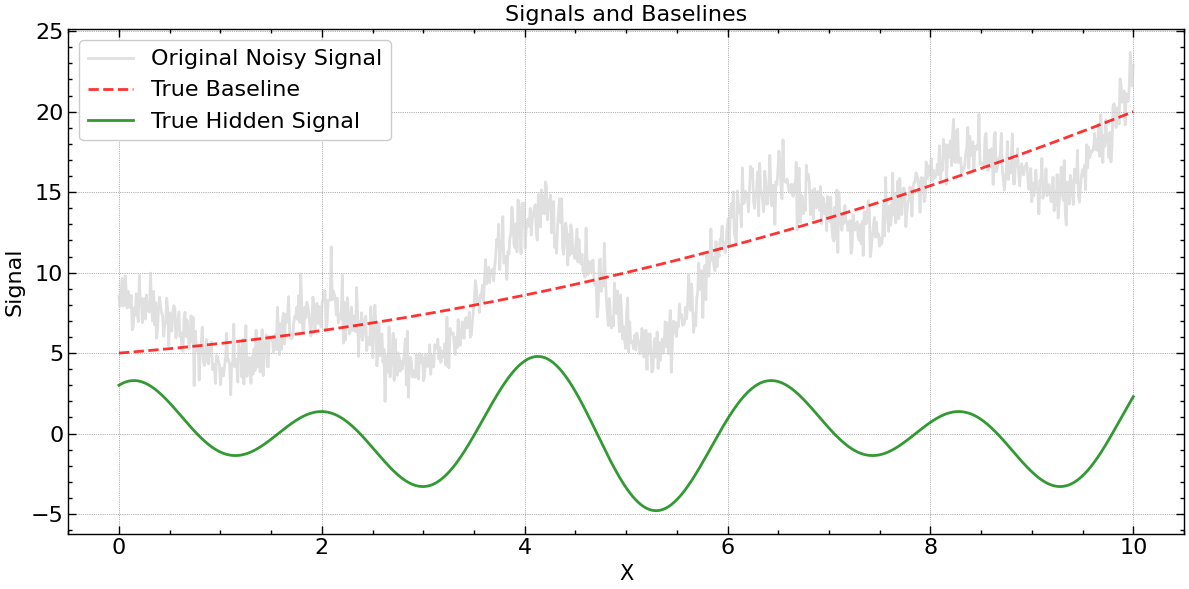

In [3]:
plt.figure(figsize=(12, 6))

plt.plot(x, y_noisy, label='Original Noisy Signal', color='lightgrey', alpha=0.7, zorder=1)
plt.plot(x, baseline, label='True Baseline', color='red', linestyle='--', alpha=0.8, zorder=2)
plt.plot(x, y_true, label='True Hidden Signal', color='green', alpha=0.8, zorder=4)
plt.title('Signals and Baselines', fontsize=16)
plt.xlabel('X', fontsize=15)
plt.ylabel('Signal', fontsize=16)
plt.legend(fontsize=16, loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

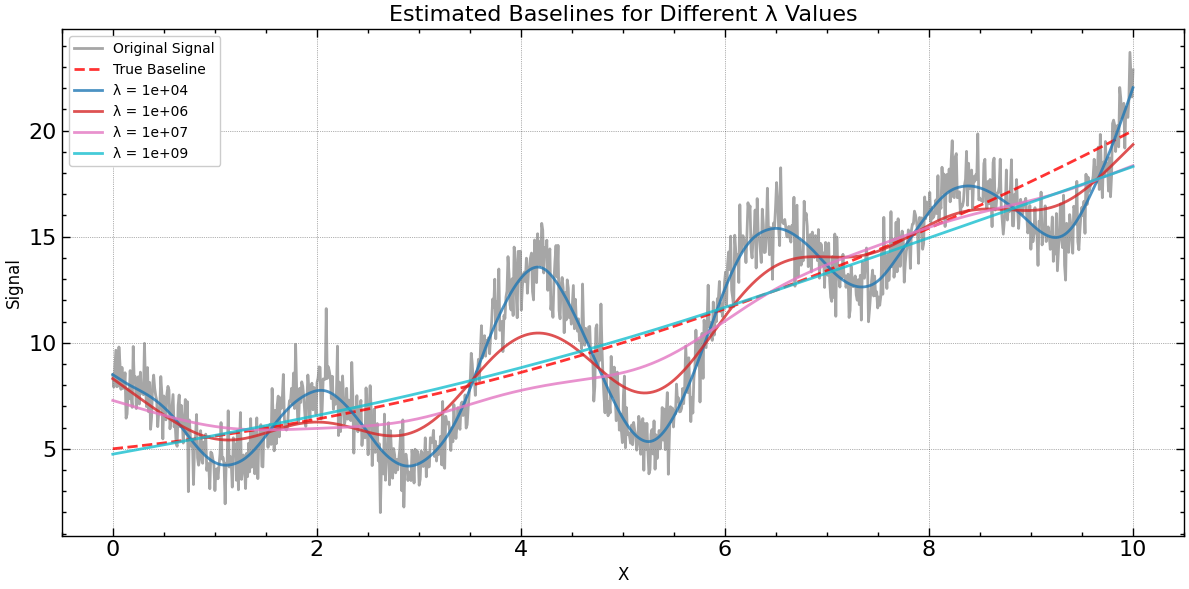

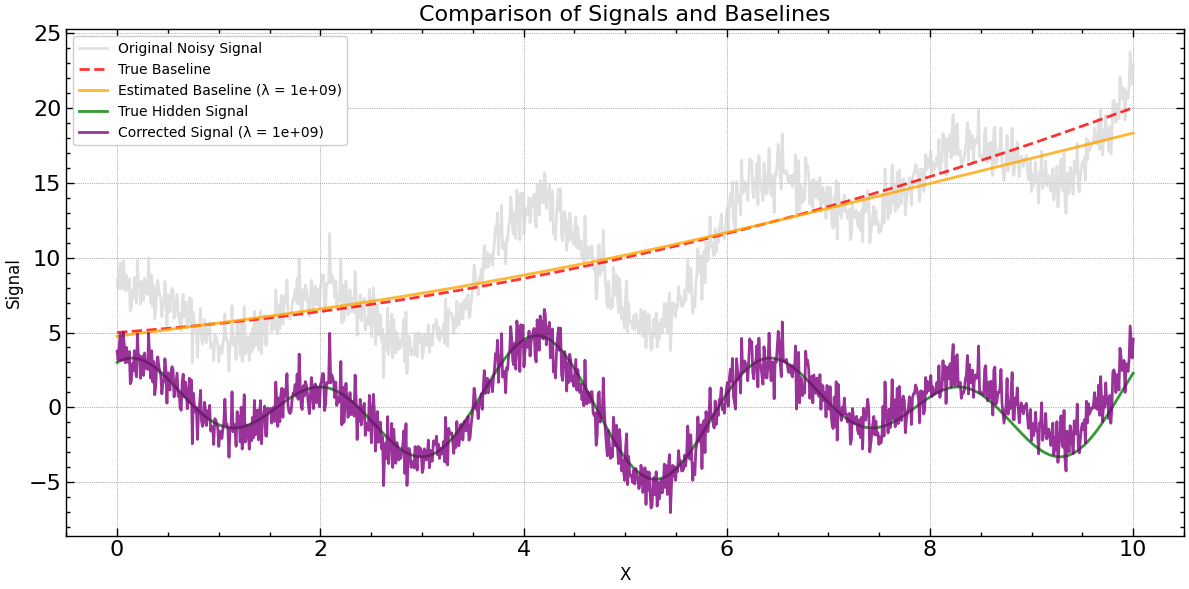

In [4]:
# Define lambda values
lambda_values = [1e4, 1e6, 1e7, 1e9]

# Color palette
colors = plt.cm.tab10(np.linspace(0, 1, len(lambda_values)))

# plot: different lambda values
plt.figure(figsize=(12, 6))
plt.plot(x, y_noisy, label='Original Signal', color='grey', alpha=0.7, zorder=1)
plt.plot(x, baseline, label='True Baseline', color='red', linestyle='--', alpha=0.8, zorder=2)

for i, lam in enumerate(lambda_values):
    baseline_est = bc.adaptive_arpls(y_noisy, lam=lam)
    plt.plot(x, baseline_est, label=f'λ = {lam:.0e}', color=colors[i], alpha=0.8, zorder=3+i)

plt.title('Estimated Baselines for Different λ Values', fontsize=16)
plt.xlabel('X', fontsize=12)
plt.ylabel('Signal', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

#  plot: corrected signal, original signal, true baseline, true signal, and estimated baseline
plt.figure(figsize=(12, 6))

# Use a sample lambda value for the correction
middle_lam = 1e9
baseline_est = bc.adaptive_arpls(y_noisy, lam=middle_lam)
corrected_signal = y_noisy - baseline_est

plt.plot(x, y_noisy, label='Original Noisy Signal', color='lightgrey', alpha=0.7, zorder=1)
plt.plot(x, baseline, label='True Baseline', color='red', linestyle='--', alpha=0.8, zorder=2)
plt.plot(x, baseline_est, label=f'Estimated Baseline (λ = {middle_lam:.0e})', color='orange', alpha=0.8, zorder=3)
plt.plot(x, y_true, label='True Hidden Signal', color='green', alpha=0.8, zorder=4)
plt.plot(x, corrected_signal, label=f'Corrected Signal (λ = {middle_lam:.0e})', color='purple', alpha=0.8, zorder=5)

plt.title('Comparison of Signals and Baselines', fontsize=16)
plt.xlabel('X', fontsize=12)
plt.ylabel('Signal', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()


In [5]:
# Set seaborn style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
sns.set_palette("tab10")


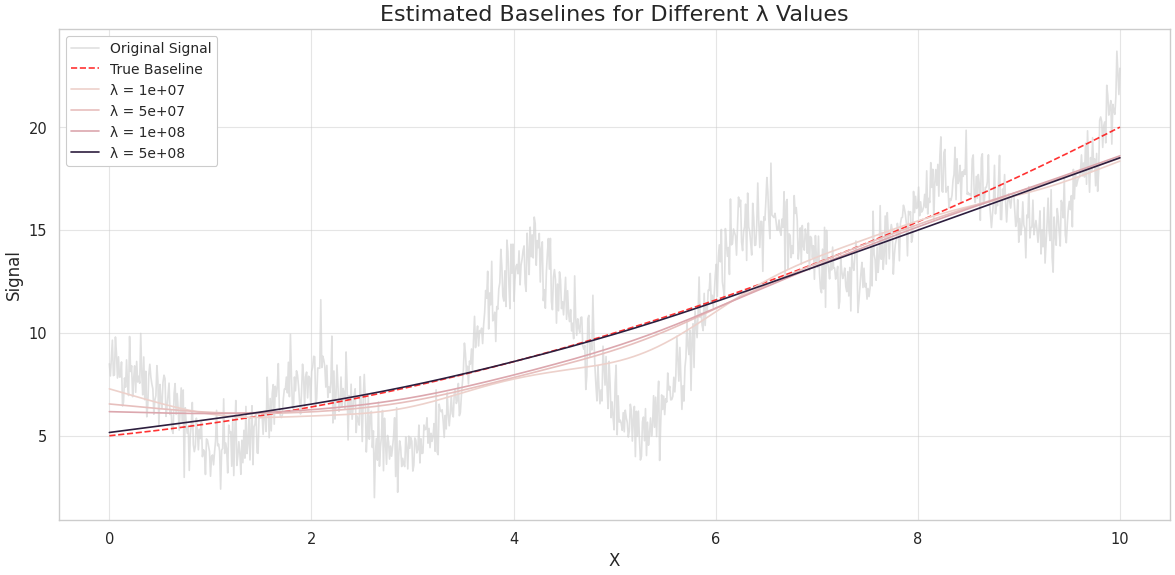

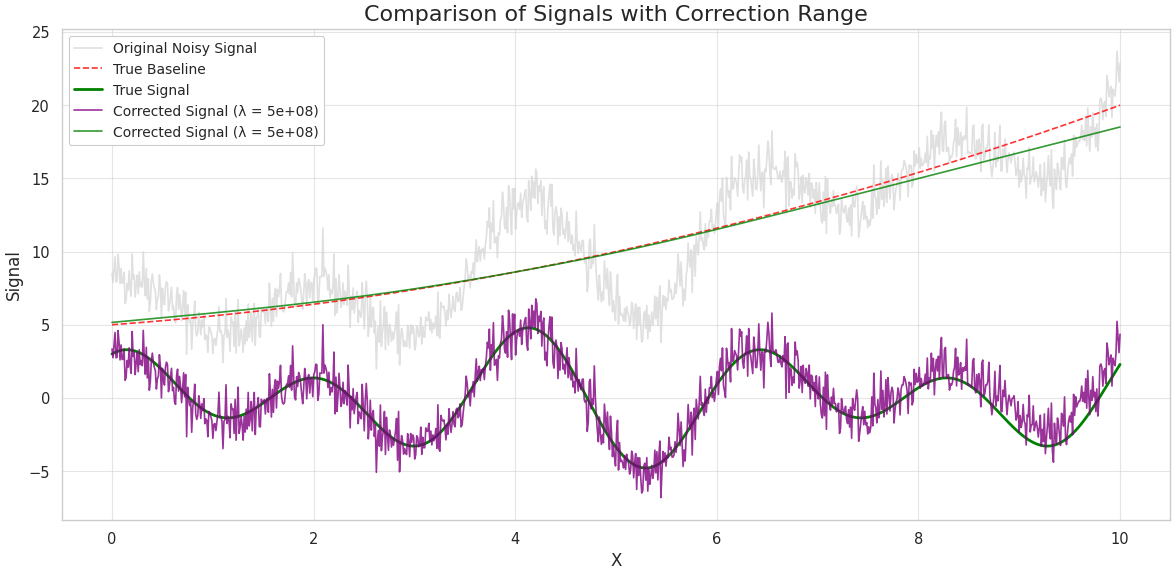

In [6]:
# Define lambda values
lambda_values = [1e7, 1e8 /2, 1e8, 1e9 /2]

# Create a pandas DataFrame to store all data
data = {
    'x': x,
    'y_true': y_true,
    'baseline': baseline,
    'y_noisy': y_noisy
}

for lam in lambda_values:
    baseline_est = bc.adaptive_arpls(y_noisy, lam=lam)
    corrected_signal = y_noisy - baseline_est
    data[f'baseline_est_{lam}'] = baseline_est
    data[f'corrected_signal_{lam}'] = corrected_signal

df = pd.DataFrame(data)

# Melt the DataFrame for easier categorical plotting
df_melted = df.melt(id_vars=['x'], 
                    value_vars=[f'baseline_est_{lam}' for lam in lambda_values],
                    var_name='lambda', value_name='baseline_est')
df_melted['lambda'] = df_melted['lambda'].apply(lambda x: float(x.split('_')[-1]))

# Create first plot: different lambda values
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='x', y='y_noisy', label='Original Signal', color='lightgrey', alpha=0.7)
sns.lineplot(data=df, x='x', y='baseline', label='True Baseline', color='red', linestyle='--', alpha=0.8)
sns.lineplot(data=df_melted, x='x', y='baseline_est', hue='lambda')

plt.title('Estimated Baselines for Different λ Values', fontsize=16)
plt.xlabel('X', fontsize=12)
plt.ylabel('Signal', fontsize=12)

# Modify the legend to show lambda values in scientific notation
handles, labels = plt.gca().get_legend_handles_labels()
scientific_labels = ['Original Signal', 'True Baseline'] + [f'λ = {lam:.0e}' for lam in lambda_values]
plt.legend(handles, scientific_labels, fontsize=10, title='', loc='upper left')

plt.tight_layout()
plt.show()

# Create second plot: corrected signal envelope, original signal, true baseline, true signal
plt.figure(figsize=(12, 6))

# Plot other lines
sns.lineplot(data=df, x='x', y='y_noisy', label='Original Noisy Signal', color='lightgrey', alpha=0.7)
sns.lineplot(data=df, x='x', y='baseline', label='True Baseline', color='red', linestyle='--', alpha=0.8)
sns.lineplot(data=df, x='x', y='y_true', label='True Signal', color='green', linewidth=2)

# Plot one corrected signal for reference (using middle lambda value)
middle_lam = 5e8
sns.lineplot(data=df, x='x', y=f'corrected_signal_{middle_lam}', 
             label=f'Corrected Signal (λ = {middle_lam:.0e})', color='purple', alpha=0.8)
sns.lineplot(data=df, x='x', y=f'baseline_est_{middle_lam}', 
             label=f'Corrected Signal (λ = {middle_lam:.0e})', color='green', alpha=0.8)

plt.title('Comparison of Signals with Correction Range', fontsize=16)
plt.xlabel('X', fontsize=12)
plt.ylabel('Signal', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()
plt.show()
